# Data Pre-processing

Converting raw data into ingredients fit for our strategy recipe is an annoying yet necessary work. Here's how I cleaned and processed data for this project.

Ultimately, we want these data:

1. Industry Index Price Series (Quarterly)
2. Industry Index Total Return Series (Quarterly)
3. Industry Index Earnings Series (Quarterly)

In [1]:
import pandas as pd
import numpy as np
import time
from tqdm import tqdm
from datetime import datetime, timedelta
from xquant.util import *
import seaborn as sns

In [2]:
df_div = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/dividends.csv', parse_dates=['announced'], dtype={'ticker':str})
df_price = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/price.csv', index_col=['date'], parse_dates=['date'])
df_mktcap = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/market_cap.csv', index_col=['date'], parse_dates=['date'])
df_comp = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/WIND_index_comp.csv', parse_dates=['included', 'excluded'])
df_map = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/ticker_map.csv', index_col=['key'])
df_idx = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/WIND_industry_index.csv', index_col=['Date'], parse_dates=['Date'])

In [3]:
# time range for back test
START = datetime(2009,1,1)
END = datetime(2020,12,31)

## Clean dividend data

In [4]:
df_div['ticker'] = df_div['ticker'].apply(add_suffix) # convert ticker symbol into standard format (e.g. 000001.SZ)

In [5]:
df_div.dropna(subset=['announced'], inplace=True)

## Clean Index Members Data

In [6]:
# map symbols to actual names of industry
df_comp['industry'] = df_comp['industry'].apply(lambda x: df_map.at[x,'value'])

In [7]:
# if stock is still a member of the index, set excluded time to a future data far away
df_comp['excluded'].fillna(pd.Timestamp('20991231'), inplace=True)

In [8]:
df_comp.dropna(subset=['included'], inplace=True)

## Calculate Financial Metrics for an Index

Very often we would need to look at certain metrics of an index, such as earnings and dividends. In a market capitalization weighted indices with $n$ components, its metric $m$ is calculated by:

$\sum^{n}_{i=1} w_{i} \cdot m_{i}$

where $w$ is the weight of component $i$ in the index (i.e. market cap of component $i$ divided by sum of market cap for all components).

### First calculate the scale (i.e. multiplier) for each industry index at a certain date

In [9]:
def get_scale(date) -> dict:
    d = dict.fromkeys(df_idx.columns,[])
    for i in df_idx.columns:
        total = 0
        f = get_index_weights(df_mktcap, df_comp.query(f"industry=='{i}'"), pd.Timestamp(date))
        for s in f.index:
            local_sum = f[s] * df_price.at[pd.Timestamp(date), s]
            if pd.notna(local_sum):
                total += local_sum
        if total != 0:            
            d[i] = df_idx.at[date,i]/total
        else:
            d[i] = np.nan
    return d

### Then calculate the quarterly weighted sum of a metric

In [10]:
def get_weighted_sum_div(start, end, df, sum_col, date_col):
    begin = time.time()
    days = [closest_trading_day(day, df_price.index, 'bfill') for day in quarter_generator(start,end)]
    df_sum = pd.DataFrame(index=days, columns=df_idx.columns)

    for day in tqdm(df_sum.index):
        if day.quarter == 1:
            look_up = (day.year-1, 4)
        else:
            look_up = (day.year, day.quarter-1)

        scale_dict = get_scale(day)
        for industry in df_idx.columns:
            w = get_index_weights(df_mktcap, df_comp.query(f"industry=='{industry}'"), day)

            weighted = {}
            multiplier = scale_dict[industry]

            for stock in w.index:
                s = quarter_sum(ticker=stock, quarter=look_up, df=df, sum_col=sum_col, date_col=date_col)
                weighted_sum = w[stock] * s
                weighted[stock] = weighted_sum

            df_sum.at[day, industry] = pd.Series(weighted, dtype=float).sum() * multiplier
    
    print(f'\ncomputation completed in {time.time()-begin} seconds.')
    return df_sum

### Quarterly Dividends

In [11]:
df_div_q = get_weighted_sum_div(START, END, df_div, 'div_per_share', 'announced')

100%|██████████| 48/48 [06:12<00:00,  7.75s/it]
computation completed in 372.11766290664673 seconds.



In [12]:
df_div_q.head()

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate
2009-01-05,0.0605388,0.155857,0.0464557,0.00641097,0.00122907,0.0316868,0.822576,0.000226169,0,0.000166051,NaN
2009-04-01,0,0.0308743,0.0258647,0.022405,0,0.0674818,0.0114135,0.00432776,0,0,NaN
2009-07-01,14.4512,5.43051,1.45323,0.465713,3.15864,2.18595,4.98365,0.23247,0.274282,1.17297,NaN
2009-10-09,7.42067,0.548186,0.350508,0.0833293,0.226286,0.635084,0.676574,0.0171919,9.26021,1.1516,NaN
2010-01-04,0,0,0.0218262,0,0,0,0.222113,0.00167726,0,0,NaN


### Quarterly Prices

This one is easy, `xquant` has a function for exactly this.

In [13]:
df_idx_q = quarter_begin(df_idx, START, END)

In [14]:
df_idx_q.head()

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate
Date,,,,,,,,,,,
2009-01-05,2208.8999,1600.1207,1548.8967,1313.5565,1753.2289,1782.7167,1438.5886,658.5682,2143.4875,1767.9462,1313.5205
2009-04-01,2951.6218,2377.8079,2187.8818,1904.1287,2143.5918,2251.6724,2005.9452,936.0047,2402.6489,2181.2383,2015.0487
2009-07-01,4022.4626,2772.2900,2487.8196,2348.1514,2569.4014,2560.5664,2830.8071,1063.4091,2867.2361,2326.3271,2895.3562
2009-10-09,4178.4873,2856.1157,2469.8611,2520.9299,2828.4802,2920.4741,2555.6294,1143.8337,2781.0105,2307.7246,2510.4421
2010-01-04,4920.1377,3417.4678,2833.8413,3211.5559,3476.0491,3502.4775,2794.2654,1491.8711,3062.7134,2508.4985,2640.6350


### Quarterly Total Return Series

Simply add the price series and dividend series together and normalize start date to 1.

In [15]:
df_total_rtn_q = df_idx_q + df_div_q.fillna(0)

In [16]:
df_total_rtn_q.head()

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate
Date,,,,,,,,,,,
2009-01-05,2208.960439,1600.276557,1548.943156,1313.562911,1753.230129,1782.748387,1439.411176,658.568426,2143.487500,1767.946366,1313.5205
2009-04-01,2951.621800,2377.838774,2187.907665,1904.151105,2143.591800,2251.739882,2005.956614,936.009028,2402.648900,2181.238300,2015.0487
2009-07-01,4036.913809,2777.720507,2489.272834,2348.617113,2572.560036,2562.752346,2835.790750,1063.641570,2867.510382,2327.500067,2895.3562
2009-10-09,4185.907970,2856.663886,2470.211608,2521.013229,2828.706486,2921.109184,2556.305974,1143.850892,2790.270709,2308.876198,2510.4421
2010-01-04,4920.137700,3417.467800,2833.863126,3211.555900,3476.049100,3502.477500,2794.487513,1491.872777,3062.713400,2508.498500,2640.6350


Might as well see what it looks like...

In [18]:
df_total_rtn_q = df_total_rtn_q.div(df_total_rtn_q.loc[df_total_rtn_q.index[0]]).mul(100)

<AxesSubplot:xlabel='Date'>

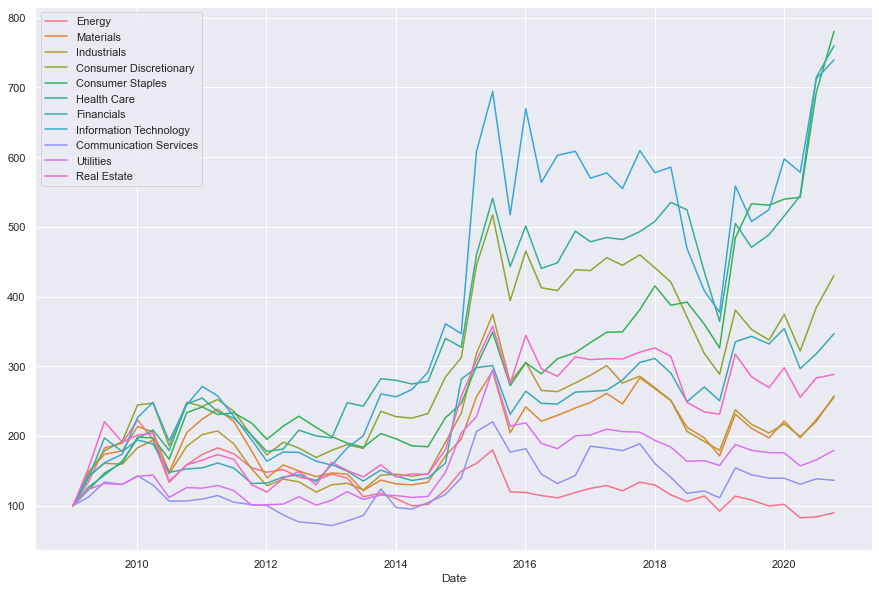

In [19]:
sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(data=df_total_rtn_q, dashes=False)

### Quarterly Earnings Series

In [20]:
df_earnings = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/earnings.csv', parse_dates=['announced'], usecols=['ticker','announced','NPAP'])

In [21]:
df_earnings['ticker'] = df_earnings['ticker'].astype(str).apply(add_suffix)

Need to tweak `get_weighted_sum_div` a little bit.

In [22]:
def get_weighted_sum_earnings(start, end, df, sum_col, date_col):
    begin = time.time()
    days = [closest_trading_day(day, df_price.index, 'bfill') for day in quarter_generator(start,end)]
    df_sum = pd.DataFrame(index=days, columns=df_idx.columns)

    for day in tqdm(df_sum.index):
        if day.quarter == 1:
            look_up = (day.year-1, 4)
        else:
            look_up = (day.year, day.quarter-1)

        scale_dict = get_scale(day)
        for industry in df_idx.columns:
            w = get_index_weights(df_mktcap, df_comp.query(f"industry=='{industry}'"), day)

            weighted = {}
            multiplier = scale_dict[industry]

            for stock in w.index:
                try:
                    eps = get_eps(
                        ticker=stock, 
                        date=day, 
                        df_price=df_price, 
                        df_mktcap=df_mktcap, 
                        df_earnings=df_earnings, 
                        earnings_col='NPAP', 
                        date_col='announced')
                except IndexError:
                    eps = 0
                weighted_sum = w[stock] * eps
                weighted[stock] = weighted_sum

            df_sum.at[day, industry] = pd.Series(weighted, dtype=float).sum() * multiplier
    
    print(f'\ncomputation completed in {time.time()-begin} seconds.')
    return df_sum

In [23]:
df_earnings_q = get_weighted_sum_earnings(START, END, df_earnings, 'NPAP', 'announced')

100%|██████████| 48/48 [13:43<00:00, 17.16s/it]
computation completed in 823.7351472377777 seconds.



In [24]:
df_earnings_q.head()

,Energy,Materials,Industrials,Consumer Discretionary,Consumer Staples,Health Care,Financials,Information Technology,Communication Services,Utilities,Real Estate
2009-01-05,101.504,80.4387,49.4858,37.9168,54.0132,51.8679,67.8585,12.2286,60.7121,17.974,NaN
2009-04-01,124.251,79.0283,57.3806,39.6002,70.1128,67.9686,72.6552,14.6201,190.333,14.6115,NaN
2009-07-01,20.7026,8.27411,10.4098,9.58992,26.9666,41.3537,21.5265,1.97484,19.5884,11.6104,NaN
2009-10-09,61.9658,19.0305,30.5651,27.5797,48.5055,58.8823,58.6555,5.55656,35.106,34.3225,NaN
2010-01-04,105.264,39.8356,42.2737,49.3541,72.346,88.2615,83.6761,11.3708,42.9106,64.9711,NaN


### Finally, scale earnings

In [26]:
df_earnings_q = df_earnings_q * (df_total_rtn_q / df_idx_q)

## Adjusting for inflation

In [27]:
df_cpi = pd.read_csv('D:/Repositories/cicc/Industry Momentum + CAPE/data/cpi.csv', parse_dates=['Date'], index_col=['Date'])

In [28]:
df_cpi = df_cpi.loc[START:END]
df_cpi = df_cpi / df_cpi['CPI'][0]
df_cpi.set_index(df_earnings_q.index, inplace=True)

In [29]:
df_cpi.head()

,CPI
2009-01-05,1.000000
2009-04-01,0.992355
2009-07-01,0.992666
2009-10-09,1.001317
2010-01-04,1.020716


In [30]:
for col in df_earnings_q.columns:
    df_earnings_q[col] = df_earnings_q[col] / df_cpi['CPI']
    df_total_rtn_q[col] = df_total_rtn_q[col] / df_cpi['CPI']
    df_idx_q[col] = df_idx_q[col] / df_cpi['CPI']
    df_div_q[col] = df_div_q[col] / df_cpi['CPI']

In [31]:
df_div_q.to_csv('data\\quarterly_dividends.csv')
df_idx_q.to_csv('data\\quarterly_prices.csv')
df_total_rtn_q.to_csv('data\\quarterly_total_returns.csv')
df_earnings_q.to_csv('data\\quarterly_earnings.csv')